# Outlook

We will now perform several improvements over the code in the previous notebook. We will:
- Combine the ProbaAgent and the ActorAgent into a single ActorAgent, so as to facilitate its use
- Introduce various agents to deal with continuous actions
- Uniformize the interactions between discrete action and continuous action agents so that they can be used interchangeably in the same A2C code
- Separate a training environment and an evaluation environment to appropriately evaluate agents from time to time during training
- Introduce tools to save, load and visualize policies and critics


The A2C algorithm is explained in [this video](https://www.youtube.com/watch?v=BUmsTlIgrBI) and you can also read [the corresponding slides](http://pages.isir.upmc.fr/~sigaud/teach/a2c.pdf).

## Installation and Imports

### Installation

The BBRL library is [here](https://github.com/osigaud/bbrl).

In [38]:
try:
    from easypip import easyimport
except:
    !pip install easypip
    from easypip import easyimport

import functools
import time

easyimport("importlib_metadata==4.13.0")
OmegaConf = easyimport("omegaconf").OmegaConf
bbrl = easyimport("bbrl")
import gym


### Imports

Below, we import standard python packages, pytorch packages and gym environments.

In [39]:
import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

import gym

### BBRL imports

In [40]:
from bbrl.agents.agent import Agent
from bbrl import get_arguments, get_class, instantiate_class

# The workspace is the main class in BBRL, this is where all data is collected and stored
from bbrl.workspace import Workspace

# Agents(agent1,agent2,agent3,...) executes the different agents the one after the other
# TemporalAgent(agent) executes an agent over multiple timesteps in the workspace, 
# or until a given condition is reached
from bbrl.agents import Agents, RemoteAgent, TemporalAgent

# AutoResetGymAgent is an agent able to execute a batch of gym environments
# with auto-resetting. These agents produce multiple variables in the workspace: 
# ’env/env_obs’, ’env/reward’, ’env/timestep’, ’env/done’, ’env/initial_state’, ’env/cumulated_reward’, 
# ... When called at timestep t=0, then the environments are automatically reset. 
# At timestep t>0, these agents will read the ’action’ variable in the workspace at time t − 1
from bbrl.agents.gymb import AutoResetGymAgent, NoAutoResetGymAgent
# Not present in the A2C version...
from bbrl.utils.logger import TFLogger

## Definition of new agents

In [this notebook](https://colab.research.google.com/drive/1yAQlrShysj4Q9EBpYM8pBsp2aXInhP7x?usp=sharing) about a simple implementation of A2C, we separated a ProbAgent and an ActorAgent. The probAgent was writing action probabilities in the workspace and the ActorAgent was reading these probabilities to choose an action. A limitation of this approach is that we absolutely need a workspace to see the output of an actor, which is not convenient for instance if we want to plot the action output for a large grid of states.

### Functions to build networks

First we define a few utilitary functions to build neural networks

In [41]:
def build_backbone(sizes, activation):
    layers = []
    for j in range(len(sizes) - 2):
        layers += [nn.Linear(sizes[j], sizes[j + 1]), activation]
    return layers


def build_mlp(sizes, activation, output_activation=nn.Identity()):
    layers = []
    for j in range(len(sizes) - 1):
        act = activation if j < len(sizes) - 2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j + 1]), act]
    return nn.Sequential(*layers)



### The DiscreteActor

The code below combines together the ProbAgent and the ActorAgent into a DiscreteActor, and adds a `predict_action(self, obs)` method to facilitate plotting from any state or other uses.

In [42]:
class DiscreteActor(Agent):
    def __init__(self, state_dim, hidden_size, n_actions):
        super().__init__()
        self.model = build_mlp([state_dim] + list(hidden_size) + [n_actions], activation=nn.ReLU())

    
    def forward(self, t, stochastic, replay=False, **kwargs):
        """ 
        Compute the action given either a time step (looking into the workspace)
        or an observation (in kwargs)
        """
        if "observation" in kwargs:
            observation = kwargs["observation"]
        else:
            observation = self.get(("env/env_obs", t))
        scores = self.model(observation)
        probs = torch.softmax(scores, dim=-1)

        if stochastic:
            action = torch.distributions.Categorical(probs).sample()
        else:
          action = probs.argmax(1)

        entropy = torch.distributions.Categorical(probs).entropy()
        logprobs = probs[torch.arange(probs.size()[0]), action].log()

        if not replay:
            self.set(("action", t), action)
        self.set(("action_logprobs", t), logprobs)
        self.set(("entropy", t), entropy)

    
    def predict_action(self, obs, stochastic):
        scores = self.model(obs)

        if stochastic:
            probs = torch.softmax(scores, dim=-1)
            action = torch.distributions.Categorical(probs).sample()
        else:
            action = scores.argmax(0)
        return action

### ContinuousActionActor classes

We define three classes to represent stochastic policies dealing with continuous actions. All these policies are stochastic, so that they can be used with RL algorithms such as A2C, TRPO, PPO or SAC. In all these policies, stochasticity is represented by using a Gaussian function as output layer of the network, and drawing actions from this Gaussian considered as the probability of each action.

The classes differ in the way the Gaussian distribution $\mathcal N(\mu, \Sigma)$ is defined.

In all the three cases, we need to define the mean $\mu$ and covariance matrix $\Sigma$ that fully define a multivariate normal distribution. Each type of actor share the fact that the mean depends upon the state $s$.

#### Constant Variance Continuous Actors

In the simplest case, the Gaussian is isotropic (its covariance matrix is $\sigma I$). This may be easier to start with, but these policies show a limited optimization capability.

On the implementation side, we use the Normal torch distribution (where each component is seen as a Gaussian), and `Independent` that allows to interpret the output of Gaussian as a multivariate distribution (one where each dimension is independent). We also define a parent class `ContinuousAgent` to implement most of the code of all the continuous agents.

In [68]:
from torch.distributions import Distribution
from torch.distributions.normal import Normal
from torch.distributions.independent import Independent

class ContinuousAgent(Agent):
    def dist(self, obs: torch.Tensor) -> Distribution:
        """Returns the distributions for the given observations"""
        assert False, "to implement in subclass"
            
    def forward(self, t, stochastic, **kwargs):
        obs = self.get(("env/env_obs", t))
        dist = self.dist(obs)

        action = dist.sample() if stochastic else dist.mean

        logp_pi = dist.log_prob(action)
        
        self.set(("entropy", t), dist.entropy())

        self.set(("action", t), action)
        self.set(("action_logprobs", t), logp_pi)


    def predict_action(self, obs, stochastic):
        """Predict just one action (without using the workspace)"""
        dist = self.dist(obs)
        action = dist.sample() if stochastic else dist.mean
        return action

We can now define the simplest of our continuous agents:

In [69]:
class ConstantVarianceContinuousActor(ContinuousAgent):
    def __init__(self, state_dim, hidden_layers, action_dim, **kwargs):
        super().__init__()
        layers = [state_dim] + list(hidden_layers) + [action_dim]
        self.model = build_mlp(layers, activation=nn.ReLU())
        self.std_param = 2

    def dist(self, obs: torch.Tensor):
        mean = self.model(obs)    
        return Independent(Normal(mean, self.std_param), 1)  # std must be positive

#### Tunable Variance continuous actors

The next agent is based on a tunable standard deviation associated with a parameter $\Sigma$. While it is theoretically possible to learn a full covariance matrix, this might prove to be difficult and for action space with a lot of dimensions, this can also be time-consuming. In practice, and here, the covariance matrix is supposed to be diagonal

$$\Sigma = diag(\theta_{var})$$

To ensure the strict positivity of the variance (the diagonal), we use a simple mechanism based on the "softplus" function

$$
\Sigma = diag(exp(1+log(\theta_{var}))
$$
where $\theta_sigma$ is a real-valued vector.

In the `TunableVarianceContinuousActor` class, the standard deviation of the Gaussian function controlling stochasticity is defined by a set of numbers which are optimized through gradient descent. These numbers are not function of the state, so stochasticity is uniform over the whole state space.

This type of policies was initially used in [the TRPO paper](http://proceedings.mlr.press/v37/schulman15.pdf), then in [the Deep RL benchmarking paper](http://proceedings.mlr.press/v48/duan16.pdf) and in [the SVPG paper](https://arxiv.org/pdf/1704.02399.pdf).

It is represented below

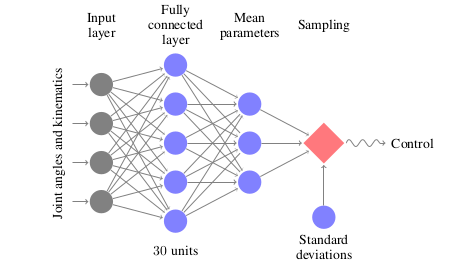

Here is the corresponding code.

In [70]:
class TunableVarianceContinuousActor(ContinuousAgent):
    def __init__(self, state_dim, hidden_layers, action_dim):
        super().__init__()
        layers = [state_dim] + list(hidden_layers) + [action_dim]
        self.model = build_mlp(layers, activation=nn.ReLU())

        # The standard deviation associated with each dimension
        self.std_param = nn.parameter.Parameter(torch.randn(action_dim, 1))
        
        # We use the softplus function to compute the variance for the normal
        # The base version computes exp(1+log(x)) component-wise
        # https://pytorch.org/docs/stable/generated/torch.nn.Softplus.html
        self.soft_plus = torch.nn.Softplus()

    def dist(self, obs: torch.Tensor):
        mean = self.model(obs)
        return Independent(Normal(mean, self.soft_plus(self.std_param)), 1)


#### State Dependent Variance Continuous Actors

Finally, the third and most complex possibility is to predict both the mean *and* the variance.

In *State Dependent Variance Continuous Actors*, The standard deviation of the Gaussian controlling stochasticity is defined as a function of the state, exactly as the mean of the Gaussian. This is the most often used representation.

As the mean and covariance matrix might share some common sources of information, the implementation below supposes that there is a *backbone* network, i.e. a function from the state space to a latent space. From this latent space, both the mean and the diagonal of the variance can be predicted (using a linear transformation, or whatever you fancy).

This type of policy is represented below.

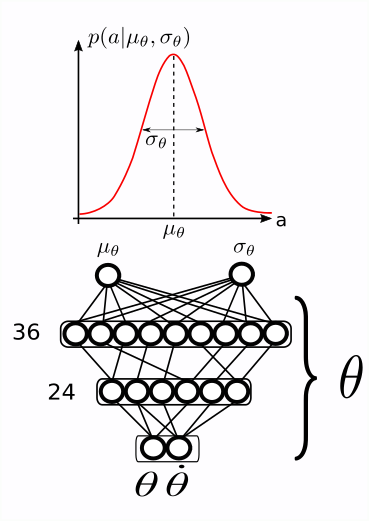

The problem with these types of policies is that neural networks are generally initialized so that their output is close to 0. Having a standard deviation close to 0 results in very few exploration, so the RL algorithm may not find any reward, hence may not learn anything. Hence the algorithm may either use an entropy loss function to tune the standard deviation to a reasonable value (as in A2C and SAC), or use an additional exploration mechanism on top of the policy stochasticity. 

Here is the skeleton corresponding code: you will have to complete the relevant parts (**exercise**)

In [73]:
class StateDependentVarianceContinuousActor(ContinuousAgent):
    def __init__(self, state_dim, hidden_layers, action_dim):
        super().__init__()

        # Buils the "backbone" neural network
        backbone_dim = [state_dim] + list(hidden_layers)
        self.layers = build_backbone(backbone_dim, activation=nn.ReLU())
        self.backbone = nn.Sequential(*self.layers)

        # À compléter...  
        assert False, 'Code non implémenté'

    
    def dist(self, obs: torch.Tensor) -> Distribution:        
        # À compléter...  
        assert False, 'Code non implémenté'


## Separating a training and an evaluation environment

As explained in [this notebook](https://colab.research.google.com/drive/1raeuB6uUVUpl-4PLArtiAoGnXj0sGjSV#scrollTo=Pl8HRPtsODc2), in BBRL, to implement the separation between training and evaluation, we build two environments: one for training, one for evaluation, and the same agent is connected to these two environments in two instances of TemporalAgent so that we train and evaluate the same network.

We explain how to implement this below.

### Choosing a specific gym environment

First, we need to make our gym environment. This is implemented with the simple function below.

In [47]:
def make_env(env_name):
    return gym.make(env_name)

### Building the training and evaluation environments

As in previous notebooks, we build two environments: one for training and another one for evaluation.

In [48]:
def get_env_agents(cfg):
    train_env_agent = AutoResetGymAgent(
        get_class(cfg.gym_env),
        get_arguments(cfg.gym_env),
        cfg.algorithm.n_envs,
        cfg.algorithm.seed,
    )
    eval_env_agent = NoAutoResetGymAgent(
    get_class(cfg.gym_env),
    get_arguments(cfg.gym_env),
    cfg.algorithm.nb_evals,
    cfg.algorithm.seed,
    )
    return train_env_agent, eval_env_agent

### CriticAgent

To implement our critic, in A2C we use the value function $V(s)$. We thus call upon the `VAgent` class,  which takes an observation as input and whose output is the value of this observation. It would be straightforward to define another CriticAgent (call it a CriticQAgent by contrast to a CriticVAgent) that would take an observation and an action as input.

 The `squeeze(-1)` removes the last dimension of the tensor.

In [49]:
class VAgent(Agent):
    def __init__(self, state_dim, hidden_layers):
        super().__init__()
        self.is_q_function = False
        self.model = build_mlp(
            [state_dim] + list(hidden_layers) + [1], activation=nn.ReLU()
        )

    def forward(self, t, **kwargs):
        observation = self.get(("env/env_obs", t))
        critic = self.model(observation).squeeze(-1)
        self.set(("v_value", t), critic)

### Building the complete training and evaluation agents

In the piece of code below, we can see that we need the observation size and the action size to build neural networks which implement the agents.

We also see that we build a different type of agent depending on whether the environment takes discrete or continuous actions.

Finally, we see how the same ActionAgent is bound to the training environment and the evaluation environment.

In [50]:
# Create the A2C Agent
def make_agents(cfg, train_env_agent, eval_env_agent):
    obs_size, act_size = train_env_agent.get_obs_and_actions_sizes()
    if train_env_agent.is_continuous_action():
        action_agent = globals()[cfg.algorithm.action_agent](
            obs_size, cfg.algorithm.architecture.actor_hidden_size, act_size
        )
    else:
        action_agent = DiscreteActor(obs_size, cfg.algorithm.architecture.actor_hidden_size, act_size)

    tr_agent = TemporalAgent(Agents(train_env_agent, action_agent))
    ev_agent = TemporalAgent(Agents(eval_env_agent, action_agent))

    critic_agent = TemporalAgent(VAgent(obs_size, cfg.algorithm.architecture.critic_hidden_size))
    return tr_agent, ev_agent, critic_agent

### The Logger class

The logger class is the same as before, see [this notebook](https://colab.research.google.com/drive/1yAQlrShysj4Q9EBpYM8pBsp2aXInhP7x#scrollTo=lU3cO6znHyDc) for explanations.

In [51]:
class Logger():

  def __init__(self, cfg):
    self.logger = instantiate_class(cfg.logger)

  def add_log(self, log_string, loss, epoch):
    self.logger.add_scalar(log_string, loss.item(), epoch)

  # Log losses
  def log_losses(self, epoch, critic_loss, entropy_loss, a2c_loss):
    self.add_log("critic_loss", critic_loss, epoch)
    self.add_log("entropy_loss", entropy_loss, epoch)
    self.add_log("a2c_loss", a2c_loss, epoch)


### Setup the optimizer

We use a single optimizer to tune the parameters of the actor and the critic. It would be possible to have two optimizers which would work separately on the parameters of each component agent, but it would be more complicated because updating the actor requires the gradient of the critic.

In [52]:
# Configure the optimizer over the a2c agent
def setup_optimizer(cfg, action_agent, critic_agent):
    optimizer_args = get_arguments(cfg.optimizer)
    parameters = nn.Sequential(action_agent, critic_agent).parameters()
    optimizer = get_class(cfg.optimizer)(parameters, **optimizer_args)
    return optimizer

### Execute agent

The call to `agent(workspace, t=1, n_steps=cfg.algorithm.n_timesteps - 1, stochastic=True)` makes the agent run a number of steps in the workspace. In practice, it calls [this function](https://github.com/facebookresearch/salina/blob/47bea8b980ca3ce2461ada82a94c2e4cc59f125d/salina/agent.py#L58) which makes a forward pass of the agent network using the workspace data and updates the workspace accordingly.

Now, if we start at the first epoch (`epoch=0`), we start from the first step (`t=0`). But when subsequently we perform the next epochs (`epoch>0`), there is a risk that we do not cover the transition at the border between the previous epoch and the current epoch. To avoid this risk, we need to shift the time indexes, hence the (`t=1`) and (`cfg.algorithm.n_timesteps - 1`).

In [53]:
def execute_agent(cfg, epoch, workspace, agent):
    if epoch > 0:
        workspace.zero_grad()
        workspace.copy_n_last_steps(1)
        agent(
            workspace, t=1, n_steps=cfg.algorithm.n_steps - 1, stochastic=True
        )
    else:
        agent(workspace, t=0, n_steps=cfg.algorithm.n_steps, stochastic=True)

### Compute critic loss

Note the `critic[1:].detach()` in the computation of the temporal difference target. The idea is that we compute this target as a function of $V(s_{t+1})$, but we do not want to apply gradient descent on this $V(s_{t+1})$, we will only apply gradient descent to the $V(s_t)$ according to this target value.

In practice, `x.detach()` detaches a computation graph from a tensor, so it avoids computing a gradient over this tensor.

Note also the trick to deal with terminal states. If the state is terminal, $V(s_{t+1})$ does not make sense. Thus we need to ignore this term. So we multiply the term by `must_bootstrap`: if `must_bootstrap` is True (converted into a float, it becomes a 1), we get the term. If `must_bootstrap` is False (=0), we are at a terminal state, so we ignore the term. This trick is used in many RL libraries, e.g. SB3.

We also show how to use the Generalized Advantage Estimate from [John Schulmann's paper](https://arxiv.org/pdf/1506.02438.pdf), with a lambda factor helping to find a better bias-variance compromize.

In [54]:
from bbrl.utils.functionalb import gae

def compute_critic_loss(cfg, reward, must_bootstrap, v_value):
    # Compute temporal difference
    # target = reward[:-1] + cfg.algorithm.discount_factor * v_value[1:].detach() * must_bootstrap.int()
    target = gae(v_value, reward, must_bootstrap, cfg.algorithm.discount_factor, cfg.algorithm.gae_coef)
    td = target - v_value[:-1]
    td_error = td**2
    critic_loss = td_error.mean()
    return critic_loss, td

### Compute Actor Loss

We compute the log probability of actions times the temporal difference error.

In [55]:
def compute_actor_loss(action_logp, td):
    a2c_loss = action_logp[:-1] * td.detach()
    return a2c_loss.mean()

## Main training loop

In [56]:
from bbrl.visu.visu_policies import plot_policy
from bbrl.visu.visu_critics import plot_critic

The main loop below is very similar to the one of the [basic version of A2C](https://colab.research.google.com/drive/1yAQlrShysj4Q9EBpYM8pBsp2aXInhP7x?usp=sharing), where some elements are explained.

A new thing in this version is that we clip the gradient on the actor's weights with the following line:

`torch.nn.utils.clip_grad_norm_(tr_agent.parameters(), cfg.algorithm.max_grad_norm)`

This is useful because the probability of some actions can be close to null, then its log is close to minus infinity, and the gradient may explode. Clipping the gradient prevents this from happening.

Note also that in the basic version the entropy was computed inside the main loop from the log probability of the actions, whereas here the entropy is written in the workspace by the agent.

In [57]:
def run_a2c(cfg):
    logger = Logger(cfg)
    best_reward = float('-inf')

    # 2) Create the environment agent
    train_env_agent, eval_env_agent = get_env_agents(cfg)
    tr_agent, eval_agent, critic_agent = make_agents(cfg, train_env_agent, eval_env_agent)

    # 5) Configure the workspace to the right dimension
    # Note that no parameter is needed to create the workspace.
    # In the training loop, calling the agent() and critic_agent()
    # will take the workspace as parameter
    train_workspace = Workspace()  # Used for training

    # 6) Configure the optimizer over the a2c agent
    optimizer = setup_optimizer(cfg, tr_agent, critic_agent)
    nb_steps = 0
    tmp_steps = 0

    # 7) Training loop
    for epoch in range(cfg.algorithm.max_epochs):
        # Execute the agent in the workspace
        if epoch > 0:
            train_workspace.zero_grad()
            train_workspace.copy_n_last_steps(1)
            tr_agent(
                train_workspace, t=1, n_steps=cfg.algorithm.n_steps - 1, stochastic=True
            )
        else:
            tr_agent(
                train_workspace, t=0, n_steps=cfg.algorithm.n_steps, stochastic=True
            )

        # Compute the critic value over the whole workspace
        critic_agent(train_workspace, n_steps=cfg.algorithm.n_steps)

        transition_workspace = train_workspace.get_transitions()

        v_value, done, truncated, reward, action, action_logp = transition_workspace[
            "v_value",
            "env/done",
            "env/truncated",
            "env/reward",
            "action",
            "action_logprobs",
        ]
        nb_steps += action[0].shape[0]
        # Determines whether values of the critic should be propagated
        # True if the episode reached a time limit or if the task was not done
        # See https://colab.research.google.com/drive/1erLbRKvdkdDy0Zn1X_JhC01s1QAt4BBj
        must_bootstrap = torch.logical_or(~done[1], truncated[1])

        # Compute critic loss
        critic_loss, td = compute_critic_loss(cfg, reward, must_bootstrap, v_value)
        a2c_loss = compute_actor_loss(action_logp, td)

        # Compute entropy loss
        entropy_loss = torch.mean(train_workspace["entropy"])

        # Store the losses for tensorboard display
        logger.log_losses(nb_steps, critic_loss, entropy_loss, a2c_loss)

        # Compute the total loss
        loss = (
            -cfg.algorithm.entropy_coef * entropy_loss
            + cfg.algorithm.critic_coef * critic_loss
            - cfg.algorithm.a2c_coef * a2c_loss
        )

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(tr_agent.parameters(), cfg.algorithm.max_grad_norm)
        optimizer.step()

        if nb_steps - tmp_steps > cfg.algorithm.eval_interval:
            tmp_steps = nb_steps
            eval_workspace = Workspace()  # Used for evaluation
            eval_agent(eval_workspace, t=0, stop_variable="env/done", stochastic=False)
            rewards = eval_workspace["env/cumulated_reward"][-1]
            mean = rewards.mean()
            logger.add_log("reward", mean, nb_steps)
            print(f"epoch: {epoch}, reward: {mean}")
            if cfg.save_best and mean > best_reward:
                best_reward = mean
                directory = "./a2c_policies/"
                if not os.path.exists(directory):
                    os.makedirs(directory)
                filename = directory + "a2c_" + str(mean.item()) + ".agt"
                policy = eval_agent.agent.agents[1]
                policy.save_model(filename)
                critic = critic_agent.agent
                if cfg.plot_policy:
                    plot_policy(
                        policy,
                        eval_env_agent,
                        "./a2c_advanced_plots/",
                        cfg.gym_env.env_name,
                        best_reward,
                        stochastic=False,
                    )
                    plot_critic(
                        critic,
                        eval_env_agent,
                        "./a2c_advanced_plots/",
                        cfg.gym_env.env_name,
                        best_reward,
                    )


## Definition of the parameters

The logger is defined as `bbrl.utils.logger.TFLogger` so as to use a tensorboard visualisation.

In [64]:
import my_gym

params={
  "save_best": True,
  "plot_policy": True,

  "logger":{
    "classname": "bbrl.utils.logger.TFLogger",
    "log_dir": "./tblogs-tp6-advanced/constant-var-actor/" + str(time.time()),
    "cache_size": 10000,
    "every_n_seconds": 10,
    "verbose": False,    
    },

  "algorithm":{
    "seed": 4,
    "n_envs": 8,
    "nb_evals":10,
    "n_steps": 16,
    "eval_interval": 1000,
    "max_epochs": 2000,
    "discount_factor": 0.95,
    "entropy_coef": 0.001,
    "critic_coef": 1.0,
    "a2c_coef": 0.1,
    "gae_coef": 0.8,
    "max_grad_norm": 0.5,
    
    # You can change the chosen action agent here
    "action_agent": "ConstantVarianceContinuousActor",
    # "action_agent": "StateDependentVarianceContinuousActor",
    # "action_agent": "TunableVarianceContinuousActor",  
    "architecture":{
      "actor_hidden_size": [25, 25],
      "critic_hidden_size": [24, 36],
    },
  },
  "gym_env":{
    "classname": "__main__.make_env",
    "env_name": "CartPoleContinuous-v1",
    },
  "optimizer":{
    "classname": "torch.optim.Adam",
    "lr": 0.01,
  }
}


### Launching tensorboard to visualize the results

In [ ]:
# For Colab - otherwise, it is easier and better to launch tensorboard from
# the terminal
if get_ipython().__class__.__module__ == "google.colab._shell":
    %load_ext tensorboard
    %tensorboard --logdir ./tmp
else:
    import sys
    import os
    import os.path as osp
    print(f'''Launch tensorboard from the shell:\n{osp.dirname(sys.executable)}/tensorboard --logdir="{os.getcwd()}/tblogs"''')

In [74]:
config=OmegaConf.create(params)
torch.manual_seed(config.algorithm.seed)
run_a2c(config)
